# Question 1

1) HDG is ProShares' ETF that attempts to track MLFM-ES by including tradable assets and attemt to model after HFRI. 


2) Normal distribution way 

3) When TIPS was dropped from the portfolio, the tangency portfolio had a marginally better annualized sharpe ratio. However, it performed slightly worse with a lower annualized mean and higher volatility recorded.

However, when we observe the cumulative returns of both portfolios, the one without TIPS had gained momentum from 2021 which can be largely due to the rise in interest rates. This is because TIPs are a direct protection to inflation and due to the rise in inflation, TIPS could have steadily grown in their expected returns. 


5) When there are many assets in the portfolio, MV optimization becomes highly unstable as the MV solution T requires us to invert the covariance matrix: $\Sigma^{-1}$. The term is highly unstable for large number of securities, giving also a unstable result. With 1,000 securities, the estimation error of means, volatilities, and covariances produce impactful errors in allocation. The latter happens due to the high sensitivity to changes in input data. If the input data in the out-of-sample is slightly different from the in-sample, the out-of-sample optimal portfolio will have considerably different weights from the in-sample.

 Regularization penalizes

In [4]:
import pandas as pd 
import numpy as np 

FILEIN = './midterm_1_data.xlsx'
sheet_exrets = 'excess returns'
sheet_spy = 'spy'
retsx = pd.read_excel(FILEIN, sheet_name=sheet_exrets).set_index('date')
spy = pd.read_excel(FILEIN, sheet_name=sheet_spy).set_index('date')

In [5]:
retsx.head()

,AAPL,MSFT,AMZN,NVDA,GOOGL,TSLA,XOM
date,,,,,,,
2016-01-15,-0.006077,-0.033445,-0.068591,-0.092883,-0.035777,-0.036346,0.030855
2016-01-22,0.045278,0.026605,0.047061,0.050539,0.050316,-0.010817,-0.011908
2016-01-29,-0.051720,0.042053,-0.027223,0.018024,0.009834,-0.067483,0.005221
2016-02-05,-0.036236,-0.096825,-0.151901,-0.104974,-0.082989,-0.156939,0.021309
2016-02-12,-0.007887,-0.000785,0.002275,-0.034052,-0.003101,-0.078688,0.013486


In [14]:
annualization_factor= 52 # since this is weekly 

def portfolio_metrics_basic(returns: pd.DataFrame) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annualized Return'] = mu.values 
    returns_df['Annualized Vol'] = vol.values 
    returns_df['Annualized SR'] = sr.values
    
    return returns_df

metrics = portfolio_metrics_basic(retsx)
metrics

,Annualized Return,Annualized Vol,Annualized SR
AAPL,0.319421,0.283883,1.125183
MSFT,0.288087,0.240206,1.199334
AMZN,0.239457,0.310389,0.771474
NVDA,0.650658,0.468096,1.390011
GOOGL,0.193328,0.274217,0.705020
TSLA,0.569728,0.607026,0.938556
XOM,0.124196,0.311613,0.398557


In [15]:
metrics['SR Rank'] = metrics['Annualized SR'].rank(ascending=False)
metrics

,Annualized Return,Annualized Vol,Annualized SR,SR Rank
AAPL,0.319421,0.283883,1.125183,3.0
MSFT,0.288087,0.240206,1.199334,2.0
AMZN,0.239457,0.310389,0.771474,5.0
NVDA,0.650658,0.468096,1.390011,1.0
GOOGL,0.193328,0.274217,0.705020,6.0
TSLA,0.569728,0.607026,0.938556,4.0
XOM,0.124196,0.311613,0.398557,7.0


Highest SR = NVDA, Lowest SR = XOM

In [47]:
# Tangency Portfolio 

def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df
    
def portfolio_returns_calc(data, weights_df): 
    return pd.DataFrame(data @ (weights_df.values)) 
    
tangency_weights_df = tangency_weights(retsx)
portfolio_returns = portfolio_returns_calc(retsx, tangency_weights_df)

tangency_weights_df

,Tangency Weights
AAPL,0.322605
MSFT,0.787496
AMZN,-0.228607
NVDA,0.495996
GOOGL,-0.502721
TSLA,0.105975
XOM,0.019257


In [20]:
metrics = portfolio_metrics_basic(portfolio_returns)
metrics

,Annualized Return,Annualized Vol,Annualized SR
0,0.563474,0.358351,1.572409


SR = 1.57. XOM had a weight of 1.93%. Asset with lowest weight had a sharpe ratio of 0.705. 


In [106]:
data = retsx.loc[:'2022']
oos_data = retsx.loc['2023':]

def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])

equal_weights_df = equal_weights(data)
portfolio_ewp = portfolio_returns_calc(data, equal_weights_df)
portfolio_ewp.columns = ['equal_weights']
portfolio_ewp.head()

tangency_weights_df = tangency_weights(data)
portfolio_tan = portfolio_returns_calc(data, tangency_weights_df)
portfolio_tan.columns = ['tan_weights']

regularized_weights_df = tangency_weights(data, scale_cov=1/3, name = 'Regularized')
portfolio_reg = portfolio_returns_calc(data, regularized_weights_df)
portfolio_reg.columns = ['reg_weights']
regularized_weights_df.head()

,Regularized Weights
AAPL,0.237267
MSFT,0.330835
AMZN,0.047178
NVDA,0.196774
GOOGL,0.011382


In [50]:
portfolios = pd.concat([
    portfolio_tan, 
    portfolio_ewp,
    portfolio_reg
], axis=1)
portfolios.columns = [_.split('_')[0] for _ in portfolios.columns]
portfolio_metrics_basic(portfolios)

,Annualized Return,Annualized Vol,Annualized SR
tan,0.471913,0.331179,1.424947
equal,0.293432,0.260804,1.125106
reg,0.325593,0.260874,1.248085


In [55]:
# GMV 
MU_TARGET = 0.005/100

def gmv_weights(returns):
    ones = np.ones(returns.columns.shape)
    cov = returns.cov()* annualization_factor
    cov_inv = np.linalg.inv(cov)
    scaling = 1/(np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_weights_df = pd.DataFrame(gmv_tot, index=returns.columns, columns=['GMV Weights'])
    return gmv_weights_df

gmv_weights_df = gmv_weights(retsx)
gmv_weights_df

,GMV Weights
AAPL,0.206231
MSFT,0.491250
AMZN,0.160866
NVDA,-0.119168
GOOGL,0.011378
TSLA,-0.046927
XOM,0.296369


<Axes: xlabel='date'>

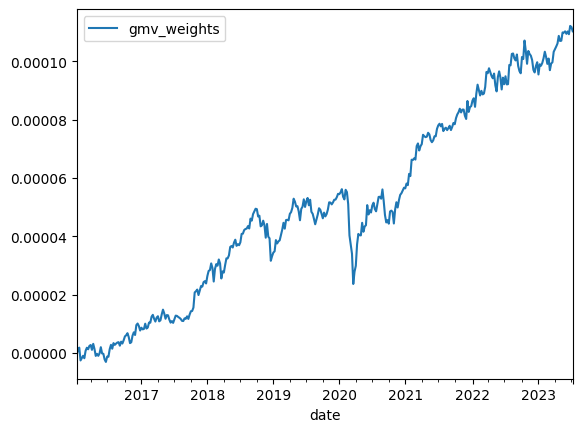

In [56]:
portfolio_gmv = portfolio_returns_calc(total_rets, gmv_weights_df)
portfolio_gmv.columns = ['gmv_weights']
portfolio_gmv = portfolio_gmv * MU_TARGET / portfolio_gmv.mean()
portfolio_gmv.plot()

In [105]:
portfolio_metrics_basic(portfolio_gmv)

,Annualized Return,Annualized Vol,Annualized SR
gmv_weights,0.0026,0.000239,10.858238


# Q3

In [61]:
tsla = retsx['TSLA']

def portfolio_metrics(returns: pd.Series) -> tuple: 
    '''
    For each individual asset's returns 
    Information Ratio, Kurtosis, Skewness, vAr, cvar, max_dd
    '''
    
    # skewness -> dimensionless data
    
    skewness = returns.skew()

    # kurtosis-> dimensionless data
    kurtosis = returns.kurtosis()
    

    # max_dd 
    cumulative = (returns + 1).cumprod()
    max_cumulative = cumulative.expanding().max()
    drawdown = cumulative / max_cumulative - 1
    max_dd = drawdown.min()
    peak_date = cumulative[:drawdown.idxmin()].idxmax().date()
    trough_date = drawdown.idxmin().date()
    recovery_date = cumulative[cumulative.index > drawdown.idxmin()].apply(lambda x: x >= max_cumulative[drawdown.idxmin()]).idxmax()

    if pd.isna(recovery_date):
        recovery_period = np.nan  # No recovery occurred
    else:
        recovery_date = recovery_date.date()
        recovery_period = (recovery_date - trough_date).days


    return skewness, kurtosis, max_dd, trough_date, peak_date, recovery_date, recovery_period


s, k, max_dd_s, min_dates, peak_dates, recoveries, recovery_periods = portfolio_metrics(tsla)

s, k

(0.44145458268186166, 1.5273762473269983)

<Axes: >

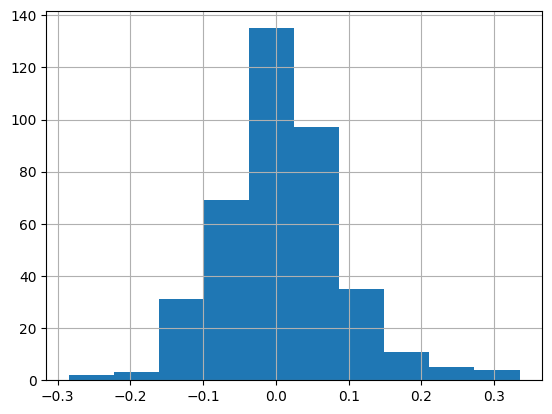

In [63]:
tsla.hist()

The returns are positively skewed. This indicates more big positive returns than negative returns.
The returns are leptokurtic, such that it has heavier tails. This implies that outsized returns are more frequent than a normal distribution

In [64]:
max_dd_s

-0.6821852296331565

In [73]:
tsla

# spy
combined_data = pd.merge(tsla, spy, on = tsla.index).rename(columns = {'key_0':'Date'}).set_index('Date')

combined_data

,TSLA,SPY
Date,,
2016-01-15,-0.036346,-0.021430
2016-01-22,-0.010817,0.014429
2016-01-29,-0.067483,0.016801
2016-02-05,-0.156939,-0.029789
2016-02-12,-0.078688,-0.007023
...,...,...
2023-06-16,0.066761,0.026036
2023-06-23,-0.017497,-0.014222
2023-06-30,0.025297,0.023245


For TSLA, calculate the following metrics, relative to SPY:

means TSLA: y variable, regress against x

In [78]:
import statsmodels.api as sm

x_variable = 'SPY' 
y_variable = 'TSLA'

def eval_performance(data, y_variable, x_variable: str):
    y = data[y_variable]
    x = sm.add_constant(data[x_variable])
    
    model = sm.OLS(y, x).fit()

    # Betas need not be annualized 
    beta = model.params[x_variable] # beta term (can be seen as the optimal hedge ratio) 
    annualized_alpha = model.params['const'] * annualization_factor # alpha term
    
    residuals = model.resid 
    std_error = np.std(residuals, ddof=1)

    annualized_return = data.mean() * annualization_factor 
    annualized_sortino_ratio = annualized_return / (data[data<0].std() * np.sqrt(annualization_factor))

    return beta, alpha, annualized_sortino_ratio


beta, alpha, annualized_sortino_ratio = eval_performance(combined_data, y_variable, x_variable)
beta, alpha, annualized_sortino_ratio


(1.776824531444384,
 0.005951353443660339,
 TSLA    1.642329
 SPY     1.003082
 dtype: float64)

In [80]:
from scipy.stats import norm

# normal formula 
-norm.pdf(1.65) / 0.05 * tsla


date
2016-01-15    0.074338
2016-01-22    0.022123
2016-01-29    0.138022
2016-02-05    0.320988
2016-02-12    0.160941
                ...   
2023-06-16   -0.136546
2023-06-23    0.035787
2023-06-30   -0.051741
2023-07-07   -0.136657
2023-07-14   -0.009849
Name: TSLA, Length: 392, dtype: float64

# Q4: hedging

In [117]:
y = 'NVDA' 
l = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
x = [i for i in l if i != y]



def get_params(data, y_col: str, x_col: list):
    columns = ['Alpha', 'R-Squared'] + x_col + ['Tracking Error']
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    
    x = sm.add_constant(x)
    model_alpha = sm.OLS(y, x).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    p_values_model_alpha = model_alpha.pvalues
    
    tracking_error_alpha = (model_alpha.resid).std()*np.sqrt(annualization_factor)
    
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) + [tracking_error_alpha]
    params_df['With Intercept'] = parameters

    return params_df 


# summary['Sortino Ratio'] = summary['Fitted Mean'] / y[y < 0].std()    # 
# summary['Annualized Sortino Ratio'] = summary['Sortino Ratio'] * np.sqrt(annual_factor)


params_df = get_params(retsx, y, x)

params_df



/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_8114/3996829784.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_model_alpha = model_alpha.params[0]


,With Intercept
Alpha,0.005264
R-Squared,0.458168
AAPL,0.341686
AMZN,0.417260
GOOGL,-0.007848
MSFT,0.587897
Tracking Error,0.344562


In [118]:
params = params_df.iloc[params_df.index.isin(x)]['With Intercept'] * 100*10**6 * (-1)
params

AAPL    -3.416865e+07
AMZN    -4.172599e+07
GOOGL    7.847952e+05
MSFT    -5.878967e+07
Name: With Intercept, dtype: float64

The hedge does marginally well with up to 46% of the time based on the R**2 value. 

Tracking error is 0.344562. (volatility of the basis)

In [120]:
annualized_alpha = 0.005264 * annualization_factor
annualized_alpha

0.27372799999999997

The intercept is 0.25. The factors do not perfectly hedge out nvda as nvda had an additional outperformance not explained for by the other tech stocks. the nature of returns of NVDA is far superior than the others. 